In [1]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import sys
import time
import math
from itertools import combinations
from functools import reduce
import constraint as c 

# Allows me to import my modules
sys.path.append('./modules')
from audio_utils import *
import data_augmentation as data_aug

Attempting to read settings file...
	Read successfully!


In [2]:
augmented_fd = get_file_classes("pre_multiclass_augmented")

In [3]:
cropped_fd = get_file_classes("cropped")

In [4]:
print("cropped amount:", len(cropped_fd), "\tpre_auged amount:", len(augmented_fd))

cropped amount: 147 	pre_auged amount: 18228


In [5]:
hit_breakdown = {hl: [] for hl in SETTINGS.label["hit_label"]}
for hl in SETTINGS.label["hit_label"]:
    for kl in SETTINGS.hierarchy[hl].keys():
        for tl in SETTINGS.hierarchy[hl][kl]:
            hit_breakdown[hl].append("-".join([kl, tl]))

In [6]:
hit_breakdown

{'beater': ['bass_drum-normal'],
 'stick': ['hi_hat-normal',
  'hi_hat-open',
  'mid_tom-normal',
  'low_tom-normal',
  'snare-normal',
  'high_tom-normal',
  'ride-normal',
  'ride-bell',
  'crash-normal']}

In [7]:
def unique_kit_class(*ts):
    current_kt = ts[0].split("-")[0]
    for t in ts[1:]:
        kt = t.split("-")[0]
        if kt == current_kt:
            return False
    return True

In [8]:
def kit_combinations():
    hit_combos = SETTINGS.data["multiclassed"]["hit_combinations"]
    hit_breakdown = {hl: [] for hl in SETTINGS.label["hit_label"]}
    for hl in SETTINGS.label["hit_label"]:
        for kl in SETTINGS.hierarchy[hl].keys():
            for tl in SETTINGS.hierarchy[hl][kl]:
                hit_breakdown[hl].append("-".join([kl, tl]))
    kit_combos = []
    for hc in hit_combos:
        prob = c.Problem()
        var_i = 0
        for ht in hc:
            prob.addVariable(str(var_i), hit_breakdown[ht])
            var_i += 1
        # Kit type contraint (they must be unique)
        prob.addConstraint(unique_kit_class)
        # Remove permutations of hits
        kit_combo_subset = list(reduce(lambda acc, x: [*acc, set(x.values())] if set(x.values()) not in acc else acc, prob.getSolutions(), []))
        kit_combo_subset = list(filter(lambda x: x not in kit_combos, kit_combo_subset))
        kit_combos.extend(kit_combo_subset)
    return kit_combos

In [9]:
kcs = kit_combinations()

In [10]:
kltl_count = {}
for kltl in hit_breakdown["beater"]+hit_breakdown["stick"]:
    count = 0
    for kc in kcs:
        if kltl in kc:
            count += 1
    kltl_count[kltl] = count

In [11]:
kltl_count

{'bass_drum-normal': 44,
 'crash-normal': 18,
 'hi_hat-normal': 16,
 'hi_hat-open': 16,
 'high_tom-normal': 18,
 'low_tom-normal': 18,
 'mid_tom-normal': 18,
 'ride-bell': 16,
 'ride-normal': 16,
 'snare-normal': 18}

In [12]:
## SHOULD BE 87 NOT 97, if the latter restart the terminal as some kit combos were repeated
print(len(kcs))
kcs

87


[{'bass_drum-normal'},
 {'crash-normal'},
 {'ride-bell'},
 {'ride-normal'},
 {'high_tom-normal'},
 {'snare-normal'},
 {'low_tom-normal'},
 {'mid_tom-normal'},
 {'hi_hat-open'},
 {'hi_hat-normal'},
 {'bass_drum-normal', 'crash-normal'},
 {'bass_drum-normal', 'ride-bell'},
 {'bass_drum-normal', 'ride-normal'},
 {'bass_drum-normal', 'high_tom-normal'},
 {'bass_drum-normal', 'snare-normal'},
 {'bass_drum-normal', 'low_tom-normal'},
 {'bass_drum-normal', 'mid_tom-normal'},
 {'bass_drum-normal', 'hi_hat-open'},
 {'bass_drum-normal', 'hi_hat-normal'},
 {'crash-normal', 'ride-bell'},
 {'crash-normal', 'ride-normal'},
 {'crash-normal', 'high_tom-normal'},
 {'crash-normal', 'snare-normal'},
 {'crash-normal', 'low_tom-normal'},
 {'crash-normal', 'mid_tom-normal'},
 {'crash-normal', 'hi_hat-open'},
 {'crash-normal', 'hi_hat-normal'},
 {'high_tom-normal', 'ride-bell'},
 {'ride-bell', 'snare-normal'},
 {'low_tom-normal', 'ride-bell'},
 {'mid_tom-normal', 'ride-bell'},
 {'hi_hat-open', 'ride-bell'},


In [13]:
fds = augmented_fd
fd_categorised = {kltl: [] for kltl in hit_breakdown["beater"]+hit_breakdown["stick"]}
for fd in fds:
    for kltl in fd_categorised.keys():
        kl, tl = kltl.split("-")
        if (kl in fd["labels"]["kit_label"] and tl in fd["labels"]["tech_label"]):
            fd_categorised[kltl].append(fd)
fd_categorised

{'bass_drum-normal': [{'augmentations': {'pre_augs': ['amplitude']},
   'filepath': 'audio_data\\pre-multiclass_augmented_data\\amplitude\\beater\\bass_drum\\normal\\0.gz',
   'labels': {'hit_label': ['beater'],
    'kit_label': ['bass_drum'],
    'tech_label': ['normal']}},
  {'augmentations': {'pre_augs': ['amplitude']},
   'filepath': 'audio_data\\pre-multiclass_augmented_data\\amplitude\\beater\\bass_drum\\normal\\1.gz',
   'labels': {'hit_label': ['beater'],
    'kit_label': ['bass_drum'],
    'tech_label': ['normal']}},
  {'augmentations': {'pre_augs': ['amplitude']},
   'filepath': 'audio_data\\pre-multiclass_augmented_data\\amplitude\\beater\\bass_drum\\normal\\10.gz',
   'labels': {'hit_label': ['beater'],
    'kit_label': ['bass_drum'],
    'tech_label': ['normal']}},
  {'augmentations': {'pre_augs': ['amplitude']},
   'filepath': 'audio_data\\pre-multiclass_augmented_data\\amplitude\\beater\\bass_drum\\normal\\11.gz',
   'labels': {'hit_label': ['beater'],
    'kit_label': [

In [14]:
kltl_samples = {kltl: len(fd_categorised[kltl]) for kltl in hit_breakdown["beater"]+hit_breakdown["stick"]}
for kltl, amount in kltl_samples.items():
    count = kltl_count[kltl]
    print(kltl, amount, "/", count, "=", math.floor(amount/count))

hi_hat-normal 1364 / 16 = 85
mid_tom-normal 1364 / 18 = 75
ride-normal 1488 / 16 = 93
hi_hat-open 1612 / 16 = 100
low_tom-normal 1736 / 18 = 96
bass_drum-normal 1364 / 44 = 31
ride-bell 1488 / 16 = 93
crash-normal 1736 / 18 = 96
snare-normal 1116 / 18 = 62
high_tom-normal 1488 / 18 = 82


In [15]:
## Multiclassed -- (every augmentation comb possible, many times with no non-uniques)

kltl_iterations = {kltl: 0 for kltl in hit_breakdown["beater"]+hit_breakdown["stick"]}
for i in range(31):
    multiclassed_data = []
    for kit_combo_set in kcs:
        kc = [kltl for kltl in kit_combo_set]
        kc.sort()
        samples = np.zeros(12000, dtype=np.float32)
        labels=dict()
        augmentations=dict()
        for kltl in kc:
            file_i = kltl_iterations[kltl]
            fd = fd_categorised[kltl][file_i]
            filepath = fd["filepath"]
            try:
                new_samples = np.loadtxt(fname=filepath, dtype=np.float32)
                pad_len = 12000-len(new_samples)
                new_samples = np.pad(new_samples, (pad_len, 0), "constant", constant_values=(0))
                samples = samples + new_samples
                kltl_iterations[kltl] = (kltl_iterations[kltl] + 1) % len(fd_categorised[kltl])
            except:
                print("skipped", *sys.exc_info())
                continue
            for l in fd["labels"].keys():
                if (l not in labels.keys() and l in fd["labels"].keys()):
                    labels.update({l: [x for x in fd["labels"][l]]})
                elif (l in fd["labels"].keys()):
                    labels.update({l: labels[l]+fd["labels"][l]})
            for a in fd["augmentations"].keys():
                if (a not in augmentations.keys() and a in fd["augmentations"].keys()):
                    augmentations.update({a: [y for y in fd["augmentations"][a]]})
                elif (a in fd["augmentations"].keys()):
                    augmentations.update({a: augmentations[a]+fd["augmentations"][a]})
        multiclassed_data.append(Sample_data(labels={k:v for k,v in labels.items()}, augmentations={k:v for k,v in augmentations.items()}, data=samples, rate=SETTINGS.data["cropped"]["save_sampling_rate"]))
    save_data("multiclassed", data_set=multiclassed_data, verbose=True)

Attempting to save multiclassed data and labels...
	Saved: 87/87 files.
Attempting to save multiclassed data and labels...
	Saved: 87/87 files.
Attempting to save multiclassed data and labels...
	Saved: 87/87 files.
Attempting to save multiclassed data and labels...
	Saved: 87/87 files.
Attempting to save multiclassed data and labels...
	Saved: 87/87 files.
Attempting to save multiclassed data and labels...
	Saved: 87/87 files.
Attempting to save multiclassed data and labels...
	Saved: 87/87 files.
Attempting to save multiclassed data and labels...
	Saved: 87/87 files.
Attempting to save multiclassed data and labels...
	Saved: 87/87 files.
Attempting to save multiclassed data and labels...
	Saved: 87/87 files.
Attempting to save multiclassed data and labels...
	Saved: 87/87 files.
Attempting to save multiclassed data and labels...
	Saved: 87/87 files.
Attempting to save multiclassed data and labels...
	Saved: 87/87 files.
Attempting to save multiclassed data and labels...
	Saved: 87/87

In [16]:
multiclassed_data[12].labels

{'hit_label': ['beater', 'stick'],
 'kit_label': ['bass_drum', 'ride'],
 'tech_label': ['normal', 'normal']}

In [17]:
multiclassed_data[12].augmentations

{'pre_augs': ['translate', 'amplitude', 'pitch', 'translate']}

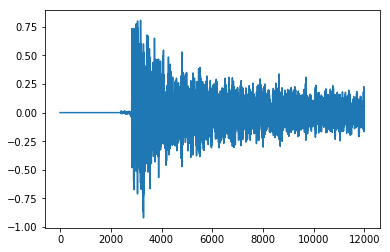

In [18]:
plt.plot(multiclassed_data[12].data)
plt.show()
ipd.Audio(multiclassed_data[12].data, rate=48000)

In [19]:
len(multiclassed_data)

87

In [20]:
multiclassed_data[0].augmentations["pre_augs"]

['translate']

In [21]:
pre_aug_stacks = data_aug.get_aug_stacks(data_aug.PRE_MULTI_AUGS)
print(len(pre_aug_stacks), pre_aug_stacks)

7 [['amplitude'], ['pitch'], ['translate'], ['amplitude', 'pitch'], ['amplitude', 'translate'], ['pitch', 'translate'], ['amplitude', 'pitch', 'translate']]


In [22]:
## Multiclassed per aug -- only audio which are in the same augmentation stack are combined
kltl_iterations = {kltl: 0 for kltl in hit_breakdown["beater"]+hit_breakdown["stick"]}
for aug_stack in pre_aug_stacks:
    fd_categorised_subset = {kltl: list(filter(lambda fd: set(fd["augmentations"]["pre_augs"]) == set(aug_stack), v)) for kltl, v in fd_categorised.items()}
    print(aug_stack)
    for kltl in kltl_iterations.keys():
        print(kltl, ":", len(fd_categorised_subset[kltl]), "/", len(fd_categorised[kltl]))
    multiclassed_data_per_aug = []
    for kit_combo_set in kcs:
        kc = [kltl for kltl in kit_combo_set]
        kc.sort()
        samples = np.zeros(12000, dtype=np.float32)
        labels=dict()
        augmentations=dict()
        for kltl in kc:
            file_i = kltl_iterations[kltl]
            fd = fd_categorised_subset[kltl][file_i]
            kltl_iterations[kltl] = (kltl_iterations[kltl] + 1) % len(fd_categorised_subset[kltl])
            filepath = fd["filepath"]
            try:
                new_samples = np.loadtxt(fname=filepath, dtype=np.float32)
                pad_len = 12000-len(new_samples)
                new_samples = np.pad(new_samples, (pad_len, 0), "constant", constant_values=(0))
                samples = samples + new_samples
            except:
                print("skipped", *sys.exc_info())
                continue
            for l in LABELS:
                if (l not in labels.keys() and l in fd["labels"].keys()):
                    labels.update({l: [x for x in fd["labels"][l]]})
                elif (l in fd["labels"].keys()):
                    labels.update({l: labels[l]+fd["labels"][l]})
            for a in AUG_KEYS:
                if (a not in augmentations.keys() and a in fd["augmentations"].keys()):
                    augmentations.update({a: [y for y in fd["augmentations"][a]]})
                elif (a in fd["augmentations"].keys()):
                    augmentations.update({a: augmentations[a]+fd["augmentations"][a]})
        multiclassed_data_per_aug.append(Sample_data(labels={k:v for k,v in labels.items()}, augmentations={k:v for k,v in augmentations.items()}, data=samples, rate=SETTINGS.data["cropped"]["save_sampling_rate"]))
    save_data("multiclassed_per_aug", data_set=multiclassed_data_per_aug, verbose=True)

['amplitude']
hi_hat-normal : 44 / 1364
mid_tom-normal : 44 / 1364
ride-normal : 48 / 1488
hi_hat-open : 52 / 1612
low_tom-normal : 56 / 1736
bass_drum-normal : 44 / 1364
ride-bell : 48 / 1488
crash-normal : 56 / 1736
snare-normal : 36 / 1116
high_tom-normal : 48 / 1488
Attempting to save multiclassed_per_aug data and labels...
	Saved: 87/87 files.
['pitch']
hi_hat-normal : 44 / 1364
mid_tom-normal : 44 / 1364
ride-normal : 48 / 1488
hi_hat-open : 52 / 1612
low_tom-normal : 56 / 1736
bass_drum-normal : 44 / 1364
ride-bell : 48 / 1488
crash-normal : 56 / 1736
snare-normal : 36 / 1116
high_tom-normal : 48 / 1488
Attempting to save multiclassed_per_aug data and labels...
	Saved: 87/87 files.
['translate']
hi_hat-normal : 44 / 1364
mid_tom-normal : 44 / 1364
ride-normal : 48 / 1488
hi_hat-open : 52 / 1612
low_tom-normal : 56 / 1736
bass_drum-normal : 44 / 1364
ride-bell : 48 / 1488
crash-normal : 56 / 1736
snare-normal : 36 / 1116
high_tom-normal : 48 / 1488
Attempting to save multiclassed

In [23]:
fd_categorised_no_augs = {kltl: [] for kltl in hit_breakdown["beater"]+hit_breakdown["stick"]}
for fd in cropped_fd:
    for kltl in fd_categorised_no_augs.keys():
        kl, tl = kltl.split("-")
        if (kl in fd["labels"]["kit_label"] and tl in fd["labels"]["tech_label"]):
            fd_categorised_no_augs[kltl].append(fd)
fd_categorised_no_augs

{'bass_drum-normal': [{'augmentations': {},
   'filepath': 'audio_data\\cropped_data\\beater\\bass_drum\\normal\\0.gz',
   'labels': {'hit_label': ['beater'],
    'kit_label': ['bass_drum'],
    'tech_label': ['normal']}},
  {'augmentations': {},
   'filepath': 'audio_data\\cropped_data\\beater\\bass_drum\\normal\\1.gz',
   'labels': {'hit_label': ['beater'],
    'kit_label': ['bass_drum'],
    'tech_label': ['normal']}},
  {'augmentations': {},
   'filepath': 'audio_data\\cropped_data\\beater\\bass_drum\\normal\\10.gz',
   'labels': {'hit_label': ['beater'],
    'kit_label': ['bass_drum'],
    'tech_label': ['normal']}},
  {'augmentations': {},
   'filepath': 'audio_data\\cropped_data\\beater\\bass_drum\\normal\\2.gz',
   'labels': {'hit_label': ['beater'],
    'kit_label': ['bass_drum'],
    'tech_label': ['normal']}},
  {'augmentations': {},
   'filepath': 'audio_data\\cropped_data\\beater\\bass_drum\\normal\\3.gz',
   'labels': {'hit_label': ['beater'],
    'kit_label': ['bass_drum

In [24]:
{kltl: len(fd_categorised_no_augs[kltl]) for kltl in hit_breakdown["beater"]+hit_breakdown["stick"]}

{'bass_drum-normal': 11,
 'crash-normal': 14,
 'hi_hat-normal': 11,
 'hi_hat-open': 13,
 'high_tom-normal': 12,
 'low_tom-normal': 14,
 'mid_tom-normal': 11,
 'ride-bell': 12,
 'ride-normal': 12,
 'snare-normal': 9}

In [25]:
## Multiclassed -- (on cropped data which wasn't augmented)
kltl_iterations = {kltl: 0 for kltl in hit_breakdown["beater"]+hit_breakdown["stick"]}
multiclassed_data_no_augs = []
for kit_combo_set in kcs:
    kc = [kltl for kltl in kit_combo_set]
    kc.sort()
    samples = np.zeros(12000, dtype=np.float32)
    labels=dict()
    for kltl in kc:
        file_i = kltl_iterations[kltl]
        fd = fd_categorised_no_augs[kltl][file_i]
        filepath = fd["filepath"]
        try:
            new_samples = np.loadtxt(fname=filepath, dtype=np.float32)
            pad_len = 12000-len(new_samples)
            new_samples = np.pad(new_samples, (pad_len, 0), "constant", constant_values=(0))
            samples = samples + new_samples
            kltl_iterations[kltl] = (kltl_iterations[kltl] + 1) % len(fd_categorised_no_augs[kltl])
        except:
            print("skipped", *sys.exc_info())
            continue
        for l in LABELS:
            if (l not in labels.keys() and l in fd["labels"].keys()):
                labels.update({l: [x for x in fd["labels"][l]]})
            elif (l in fd["labels"].keys()):
                labels.update({l: labels[l]+fd["labels"][l]})
    multiclassed_data_no_augs.append(Sample_data(labels={k:v for k,v in labels.items()}, data=samples, rate=SETTINGS.data["cropped"]["save_sampling_rate"]))
save_data("multiclassed_no_augs", data_set=multiclassed_data_no_augs, verbose=True)

Attempting to save multiclassed_no_augs data and labels...
	Saved: 87/87 files.


True